In [42]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

from matplotlib import pyplot as plt, colors
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

import numpy as np
import pandas as pd
import seaborn as sb

from scipy import stats
from fooof import FOOOFGroup

from galaxybrain.data_utils import load_results, spike_dict, mouse_iter, ALL_REGIONS
from galaxybrain.plot_utils import rc_style, pltlabel, plot_all_measures,\
                                   corr_plot, exp_plot, goodness_of_fit_plot,\
                                   avg_corr_bar, all_corr_plot, corr_heat_map, avg_exp_plot,\
                                    logaxes, solo_colorbar
rc_style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# This notebook is for investigating the results of analysis 
like correlation of subset size and average spectral exponent

Some common parameters, before I was saving them as json
 - exp5: n_iters = 95; n_pc = 0.8; f_range = [0,0.4]; pc_range = [0,1.0]
 
 
### data shapes
```python
pca_m          : (95, 16)
ft_mN          : (95, 16)
pearson_pN     : (4, 16)
spearman_pN    : (4, 16)
pca_b          : (95, 16)
ft_bN          : (95, 16)
pearson_corrN  : (4, 16)
spearman_corrN : (4, 16)
eigs           : (16,)
pows           : (16, 61)
pca_er         : (95, 16)
ft_erN         : (95, 16)
```
# Loading, plotting results

In [6]:
nosum = load_results('../data/experiments/NOSUM') # has summed and non summed data
mice = load_results('../data/experiments/exp6', kind='mouse_old')

{'n_iters': 95, 'n_pc': 0.8, 'f_range': [0, 0.4]}
{'n_iters': 95, 'n_pc': 0.8, 'f_range': [0, 0.4]}


# Spectra and exponents

(one exponent per subset size ?)

Example plot: Krebs @ all regions

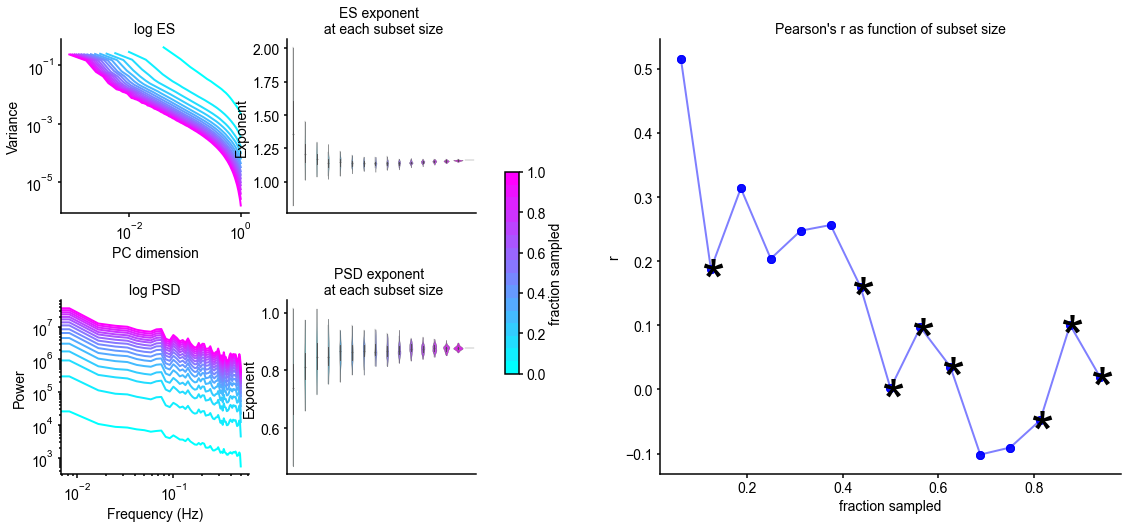

In [194]:
mouse, rgn = 'krebs', 'all'
d = nosum[mouse][rgn]
data, meta = d['data'], {**d['meta'], **nosum['meta']}
subsetsizes = meta['subsetsizes']
n_pc = meta['n_pc']
n = len(subsetsizes)

## Plot style
subset_fractions = np.linspace(0,1,n)
cmap = plt.cm.cool(subset_fractions)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", cmap)

fig = plt.figure(figsize=(19,8))
gs = GridSpec(2,3, width_ratios=[1,1,4], wspace=0.8) #
gs1 = GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[:,:2], hspace=.5)
gs2 = GridSpecFromSubplotSpec(2, 3, subplot_spec=gs[:,2])

## Spectra
for (ip, spec), labs in zip(enumerate(['eigs', 'pows']), [['log ES', 'PC dimension', 'Variance'],
                                                          ['log PSD', 'Frequency (Hz)', 'Power']]):
    ax = fig.add_subplot(gs1[ip,0])
    for i, n_i in enumerate(subsetsizes):
        if n_pc == None: #does this still need to be None?  Will it ever be manually changed?
            n_pc_curr = min(subsetsizes)
        elif isinstance(n_pc, int) and n_pc < n_i:
            n_pc_curr = n_pc
        elif isinstance(n_pc, float):
            n_pc_curr = int(n_pc*n_i)

        xvals = np.arange(1,n_pc_curr+1)/n_pc_curr if spec == 'eigs'\
           else np.arange(0,61/120, 1/120)
        # Eigenspectrum
        ax.plot(xvals, data[spec][i]) #KEEP THIS LINE: proportion of PCs
        logaxes()
        pltlabel(*labs)

## Exponent distributions
for (ip, exp), labs in zip(enumerate(['pca_m', 'ft_m1']), [['ES exponent \n at each subset size', '', 'Exponent'],
                                                           ['PSD exponent \n at each subset size', '', 'Exponent']]):
    ax = fig.add_subplot(gs1[ip,1])
    exp_plot(data, exp, ax=ax)
    pltlabel(*labs)
    
## colorbar for first two cols
cax = fig.add_axes([0.45, 0.3, 0.01, 0.35])
hexes = [colors.rgb2hex(c) for c in cmap] # VERY hacky way of getting hex values of cmap cool
solo_colorbar([hexes[0], hexes[-1]], subset_fractions, 'fraction sampled', 
              orientation='vertical', cax=cax)

## Interspec Correlation
ax = fig.add_subplot(gs2[:])
corr_plot(data['pearson_corr1'], 'Pearson',
         p_vals=data['pearson_p1'], ax=ax)

plt.tight_layout()

plt.savefig(f'../fig/mouse/spec_info_{mouse}_{rgn}.png', bbox_inches='tight', pad_inches=0.0, dpi=400)

# Summary figures
- consider either/both heatmap and bar plot for summary

TODO:

- look for any interesting subset sizes, other patterns

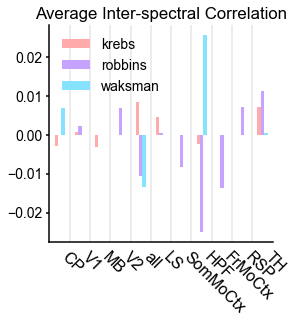

In [3]:
avg_corr_bar(mice)

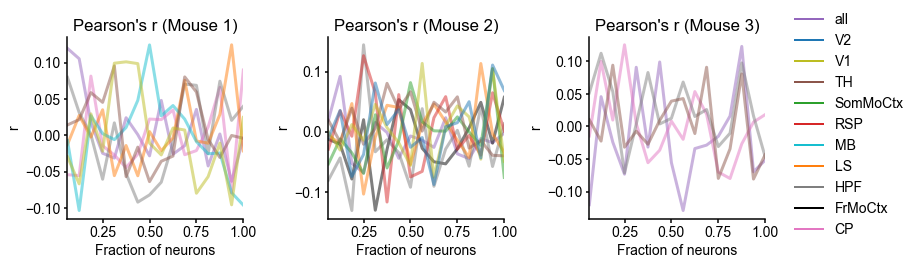

In [6]:
all_corr_plot(mice)
# plt.savefig('../fig/mouse/corr_plot1.png', bbox_inches='tight', pad_inches=0.0, dpi=400)

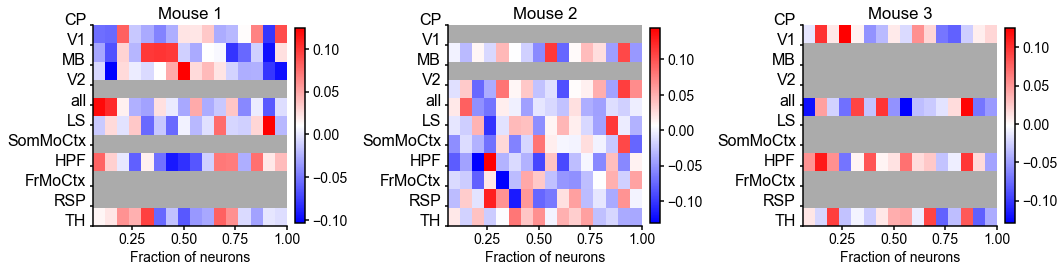

In [66]:
corr_heat_map(mice)

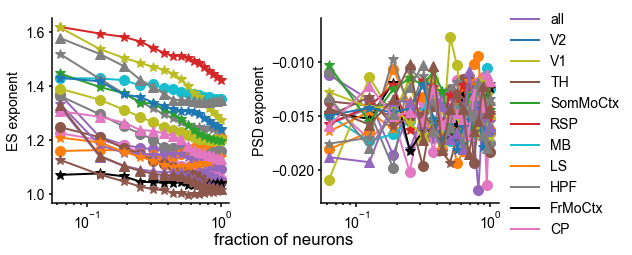

In [4]:
avg_exp_plot(mice)
plt.savefig(f'../fig/mouse/spec_exp_all_mice.png', bbox_inches='tight', pad_inches=0.0, dpi=400)

# Supplementary figures (move to sep notebook?)
### violin plots

comparing distr of exp in summ vs non sum, interestinc omparison (converging vs diverging to mean)

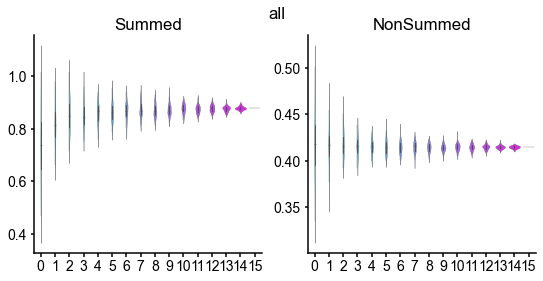

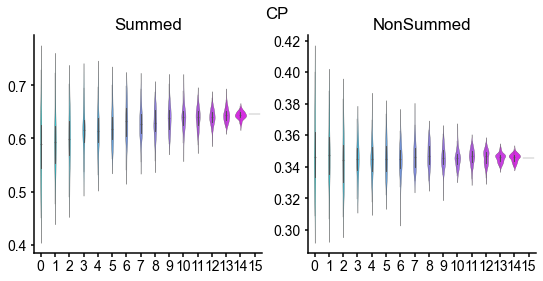

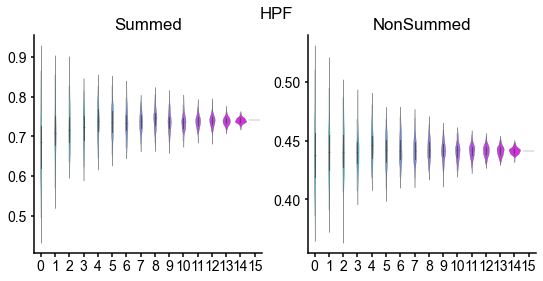

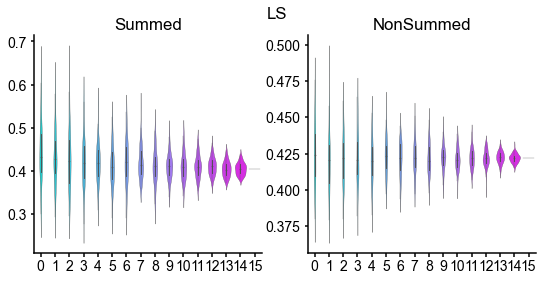

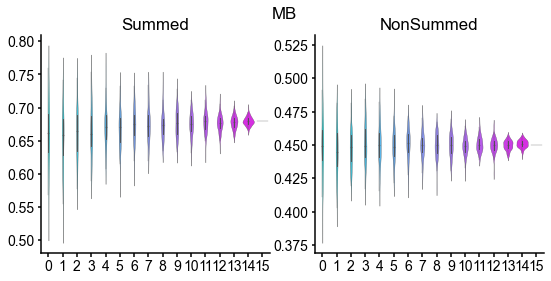

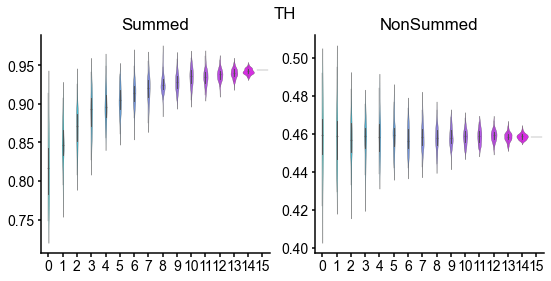

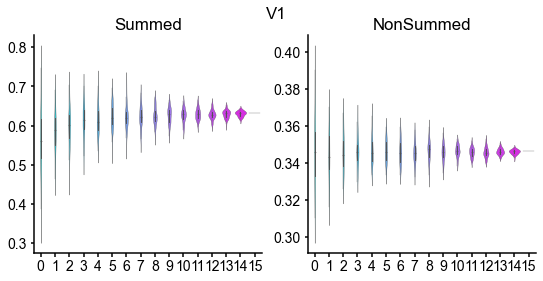

In [91]:
for rgn in nosum['krebs']:
    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    exp_plot(nosum['krebs'][rgn]['data'], 'ft_m1')
    pltlabel('Summed')
    plt.subplot(1,2,2)
    exp_plot(nosum['krebs'][rgn]['data'], 'ft_m2')
    pltlabel('Non-summed')
    plt.suptitle(rgn)

### goodness of fit

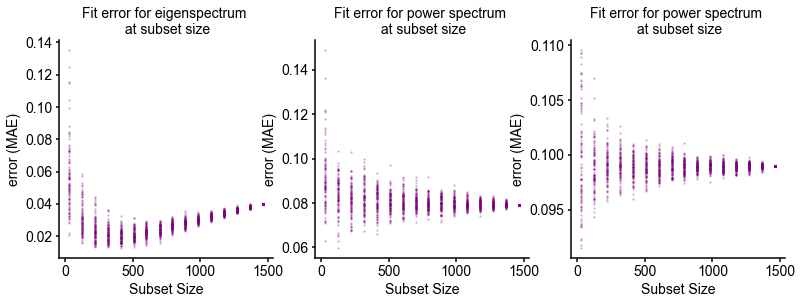

In [15]:
plt.figure(figsize=(13,4))
for i, spec in enumerate(['pca_er', 'ft_er1', 'ft_er2']):
    plt.subplot(1,3,i+1)
    goodness_of_fit_plot(d['meta']['subsetsizes'], d['data'], spec)

### Taking PSD for non summed data
- since this is not done in the pipeline

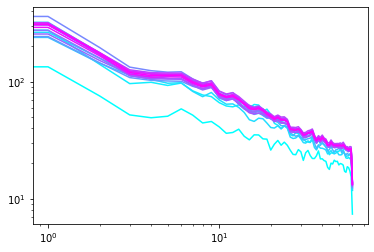

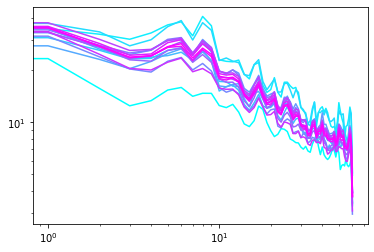

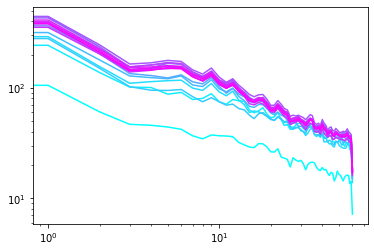

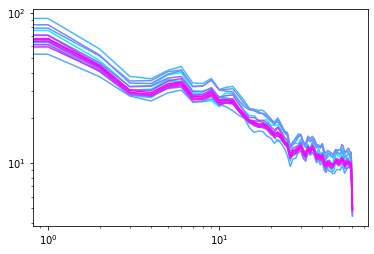

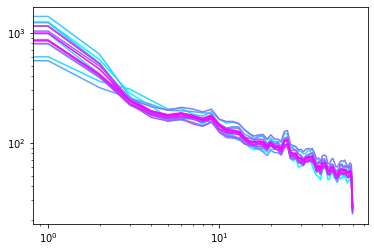

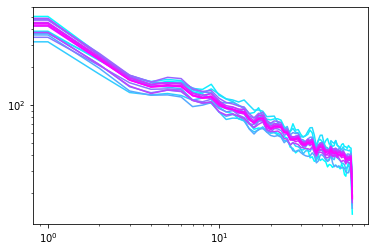

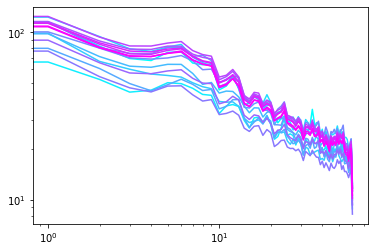

In [42]:
from galaxybrain.ramsey import ft_on_data
n_iter = 30
ft_data = {}
freqs = np.fft.rfftfreq(ft_kwargs['nperseg'])

mouse_data = mouse_iter(raster_dict, mouse_key, burn_in)
for mouse_raster, region_name, region_count in mouse_data:
    subsetsizes = np.linspace(30,region_count,16, dtype=int)
    ### DATA
    ft_data[region_name] = []
    for subset_size in subsetsizes:
        loc_array = np.sort(np.random.choice(mouse_raster.shape[1], subset_size, replace=False))
        subset = np.array(mouse_raster.iloc[:,loc_array]) #currently converted to array for test
        chan_powers_mat = np.zeros((n_iter, subset_size, len(freqs)))

        for i in range(n_iter):
            freqs, powers_sum, powers_chans = ft_on_data(subset, **ft_kwargs)
            chan_powers_mat[i] = powers_chans
        ft_data[region_name].append(chan_powers_mat.mean(0).mean(0))

colors = list(iter(plt.cm.cool(np.linspace(0, 1, 16))))
for k,v in ft_data.items():
    plt.figure()
    for i, p in enumerate(v):
        plt.loglog(p,color=colors[i])

## Correlating subset size and spectral exponent

Calculate r (pearson, spearman) for each (mouse, region) and average (since for each datum shape is 2d, (95,16)) <br>
Keep in mind each set of exponents is averaged across 4 trials (due to `decomp_arr[:,0 or 1].mean(0)`)

In [3]:
mouse_means_eigx = {'pearson': ([],[]), 'spearman': ([],[])} # see below
mouse_means_psdx = {'pearson': ([],[]), 'spearman': ([],[])} # stat means ([r], [p]) for each region in each mouse, to be averaged again later 
for mouse_key in ['krebs', 'robbins', 'waksman']:
    for region in data_dict[mouse_key]:
        region_name, region_count, data = region[0], region[1], region[2]
        e_exp, p_exp = data['espec_exp'], data['psd_exp']
        subsetsizes = data['subsetsizes']
        espec_corr_array_curr = {'pearson': ([],[]), 'spearman': ([],[])}
        psd_corr_array_curr = {'pearson': ([],[]), 'spearman': ([],[])} # each correlation's array will have a correlation array and a p-value array
        for i in e_exp:
            espec_corr_array_curr['pearson'][0].append(stats.pearsonr(subsetsizes, i)[0])
            espec_corr_array_curr['pearson'][1].append(stats.pearsonr(subsetsizes, i)[1])
            
            espec_corr_array_curr['spearman'][0].append(stats.spearmanr(subsetsizes, i)[0])
            espec_corr_array_curr['spearman'][1].append(stats.spearmanr(subsetsizes, i)[1])
            
        for i in p_exp:
            psd_corr_array_curr['pearson'][0].append(stats.pearsonr(subsetsizes, i)[0])
            psd_corr_array_curr['pearson'][1].append(stats.pearsonr(subsetsizes, i)[1])
            
            psd_corr_array_curr['spearman'][0].append(stats.spearmanr(subsetsizes, i)[0])
            psd_corr_array_curr['spearman'][1].append(stats.spearmanr(subsetsizes, i)[1])
        
        region[2]['subset-exp correlation'] = {'espec': espec_corr_array_curr, 'psd': psd_corr_array_curr}
        
        #appending data for print statment below. Wow this is messy
        mouse_means_eigx['pearson'][0].append(np.mean(espec_corr_array_curr['pearson'][0]))
        mouse_means_eigx['spearman'][0].append(np.mean(espec_corr_array_curr['spearman'][0]))
        mouse_means_eigx['pearson'][1].append(np.mean(espec_corr_array_curr['pearson'][1]))
        mouse_means_eigx['spearman'][1].append(np.mean(espec_corr_array_curr['spearman'][1])) 
        
        mouse_means_psdx['pearson'][0].append(np.mean(psd_corr_array_curr['pearson'][0])); mouse_means_psdx['spearman'][0].append(np.mean(psd_corr_array_curr['spearman'][0])) 
        mouse_means_psdx['pearson'][1].append(np.mean(psd_corr_array_curr['pearson'][1])); mouse_means_psdx['spearman'][1].append(np.mean(psd_corr_array_curr['spearman'][1])) 

e_p_m, e_p_p = np.mean(mouse_means_eigx['pearson'][0]), np.mean(mouse_means_eigx['pearson'][1]); e_s_m, e_s_p = np.mean(mouse_means_eigx['spearman'][0]), np.mean(mouse_means_eigx['spearman'][1])
p_p_m, p_p_p = np.mean(mouse_means_psdx['pearson'][0]), np.mean(mouse_means_psdx['pearson'][1]); p_s_m, p_s_p = np.mean(mouse_means_psdx['spearman'][0]), np.mean(mouse_means_psdx['spearman'][1]) 
print('Eigenspectrum: avg subset-exp correlation pearson r:{:.4f}, p:{:.4f}, spearman r:{:.4f}, p:{:.4f}'.format(e_p_m, e_p_p, e_s_m, e_s_p))
print('PSD: avg subset-exp correlation pearson r:{:.4f}, p:{:.4f}, spearman r:{:.4f}, p:{:.4f}'.format(p_p_m, p_p_p, p_s_m, p_s_p))

Eigenspectrum: avg subset-exp correlation pearson r:-0.6349, p:0.0359, spearman r:-0.6553, p:0.0640
PSD: avg subset-exp correlation pearson r:0.4077, p:0.1540, spearman r:0.4169, p:0.1823
